# The Goal of this Project is to code a classifier and regressor decision tree that can be used with the following API:

```
df = pd.read_csv("data.csv")

train_df, test_df = sp.train_test_split(df, test_size = 0.2)
tree = dt.train(train_df)
predictions = dt.predict(test_df, tree)
accuracy = dt.calculate_accuracy(predictions, tree)

```

The algorithm that is going to be implemented looks like this:

<img src="https://raw.githubusercontent.com/SebastianMantey/Decision-Tree-from-Scratch/master/images/decision_tree_algorithm_1.png" width="350">

## Import Statements

In [462]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random


In [463]:
%matplotlib inline
sns.set_style("darkgrid")

# Load and Prepare Data

#### Format of the data
- the last column of the data frame must contain the label and it must also be called "label"
- there should be no missing values in the data frame

In [464]:
df = pd.read_csv("../data/Iris.csv")
df = df.drop("Id", axis=1)
df = df.rename(columns={"species": "label"})

In [465]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# Train-Test-Split

In [466]:
def train_test_split(df : pd.DataFrame, test_size):
    """ this function splits the data frame into to sub-frames, first for training the model second to test """
    # checks if the test_size is a portion or amount
    if isinstance(test_size, float):
        # if portion calculate the amount
        test_size = round(test_size * len(df))
    # generate a list of indices in the data frame
    indices = df.index.tolist()

    # pick the indices of the amount required randomly
    test_indices = random.sample(population = indices, k=test_size)

    # locate the test indices to a new dataframe (test dataframe)
    test_df = df.loc[test_indices]
    # drop the test indices to get the train data frame
    train_df = df.drop(test_indices)
    
    return train_df, test_df

#### API Testing

In [467]:
train_df, test_df = train_test_split(df, test_size = 0.2)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 77 to 118
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  30 non-null     float64
 1   sepal_width   30 non-null     float64
 2   petal_length  30 non-null     float64
 3   petal_width   30 non-null     float64
 4   label         30 non-null     object 
dtypes: float64(4), object(1)
memory usage: 1.4+ KB


# Private specialized Functions
The specialized functions operate on a NumPy 2d-array.
Therefore, let’s create a variable called “data” to see what we will be working with.


In [468]:
data = train_df.values
data[:5]


array([[5.1, 3.5, 1.4, 0.2, 'Iris-setosa'],
       [4.9, 3.0, 1.4, 0.2, 'Iris-setosa'],
       [4.7, 3.2, 1.3, 0.2, 'Iris-setosa'],
       [4.6, 3.1, 1.5, 0.2, 'Iris-setosa'],
       [5.0, 3.6, 1.4, 0.2, 'Iris-setosa']], dtype=object)

### Data pure?
This function checks for purity in the data before any attempt to split

In [469]:
def check_purity(data) -> bool:
    """
    This function checks for purity in the data before any attempt to split
    :param data: data array to check its purity
    :return: true if pure , false if not
    """
    # get an array of the label column
    label_column = data[:, -1]
    # get the unique classes from the label column
    unique_classes = np.unique(label_column)
    # the data is pure if there is one class
    return len(unique_classes) == 1

### Classify | Make_Leaf
This function return the most occurred class in the data array passed to it if the task is classification
and return the mean of the label values in case of Regression.
This function will be needed when decide to stop splitting in a certain level

In [470]:
def make_leaf(data , ml_task) -> str:
    """
    This function return the most occurred class in the data array passed to it if ml_task is classification and the mean of the label vals if the ml_task is regression.

    """
    # generate array of the label column
    label_column = data[:, -1]
    if ml_task == "regression":
        leaf = np.mean(label_column)
    else: # classification
        # get the unique classes from the label column as well as number of occurrence for each class
        unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)
        # return a string of the name for the most occurred one
        index_of_max = counts_unique_classes.argmax()
        leaf = unique_classes[index_of_max]
    
    return leaf

### Type of Feature
- type of feature will decide to treat its values as continuous values or categorical

In [471]:
def type_of_features(df):
    """
    this api function return a tuple contain each feature type (continuous , categorical )
    :param df: the data frame to determine its features types
    :return: sorted tuple contains each feature type
    """
    feature_types = []
    values_threshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= values_threshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")

    return tuple(feature_types)

In [472]:
global FEATURE_TYPES
def set_feature_types(types):
    global FEATURE_TYPES
    FEATURE_TYPES = types

### Potential splits?

In [473]:

def get_potential_splits(data) -> dict:
    """
    This function return a dic contains the indices of the continues features in the data as keys
    and the values for potentially split on for each feature.
    """
    # create the dic to be returned
    potential_splits = {}
    # get the dims of the frame
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):  # excluding the last column which is the label
        # generate an array of contained the values of this col
        values = data[:, column_index]
        # extract the uniques
        unique_values = np.unique(values)
        # for each index create a list as key
        potential_splits[column_index] =list(unique_values)

    return potential_splits

#### API testing

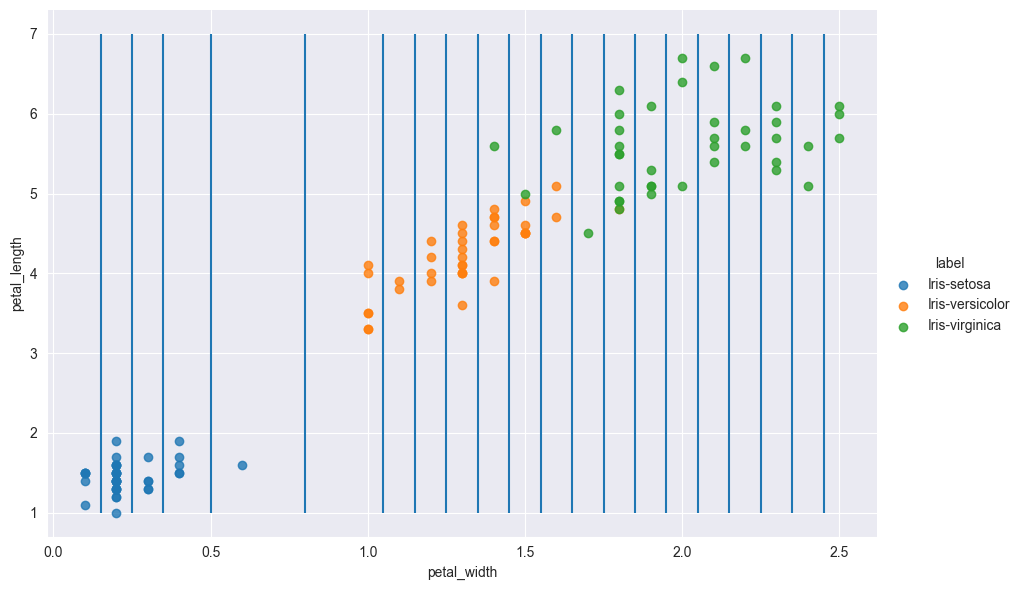

In [474]:
pot_splits = get_potential_splits(train_df.values)
sns.lmplot(data = train_df,x = "petal_width",y='petal_length',hue='label',fit_reg = False , height  = 6 , aspect = 1.5 )
lines = []
for i in range(1,len(pot_splits[3])):
    line = (pot_splits[3][i] + pot_splits[3][i-1])/2
    lines.append(line)
plt.vlines(x = lines, ymin=1 , ymax = 7) # draw potential splits of the petal width col

### Data splitting

After we become able to get a list of potential split values for each column we would like to have an api
that takes a potential value and selected col to splits the data on these parameters.


In [475]:
def split_data(data , split_column, split_value):
    """ this function split the data frame into two sub-frames based on a split value in the split col """
    feature_type = FEATURE_TYPES[split_column]
    # get an array of the values in the split col
    split_column_values = data[:, split_column]

    # if the feature is continuous
    if feature_type == 'continuous':
        # for each value below than the threshold select its row in the data_below frame
        data_below = data[split_column_values <= split_value]
        # for each value above than the threshold select its row in the data_above frame
        data_above = data[split_column_values >  split_value]
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]

    return data_below, data_above

### Entropy and Mean Squared Error Calculation Functions

After Creating the APIs that enable us from manipulating the data frames we get into the stage of calculating entropy, the methods that would help us to shape our decision tree if the task of the tree is classification,
  and Mean Squared Error (MSE) if the task is regression.

- entropy()
- mse()
- info_gain()


In [476]:
def entropy(data):
    """
    this function calculate and return the entropy of the given data frame.
    :param data: data to calculate entropy for
    :return: float number represent the entropy of the data
    """

    # we get an array contains all values in label col (classes)
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True) # counts the occurrence of each class
    # get all classes probabilities
    probabilities = counts / counts.sum()
    # calculate entropy the weighted sum of the -log all probabilities
    entropy = sum(probabilities * -np.log2(probabilities))

    return entropy

In [477]:
def mse(data):
    """
    this function returns the mean squared error of the data given to it.
    :param data: data to calculate mse for.
    :return: float number represents the mse value.
    """
    # we get an array contains all values in label col
    actual_values = data[:, -1]
    # checks for empty array of data , then mse is zero
    if len(actual_values) == 0:   # empty data
        mse = 0

    else: # data frame is not empty
        # mse = (1/n) * sum(actual - predict)^2
        # so we first get the predicted value as it is the mean of all values.
        prediction = np.mean(actual_values)
        mse = np.mean((actual_values - prediction) ** 2)

    return mse

In [478]:
def overall_metric(data_below, data_above , metric_method):
    """ this function calculate the overall gain of splitted data ,
    E(data ) - ( w1.E(left_branch) + w2.E(right_branch) )  """
    # calculate the wights of the two branches
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n
    # calculate overall entropy and return it
    overall = (p_data_below * metric_method(data_below)
                       + p_data_above * metric_method(data_above))

    return overall

In [479]:
def info_gain(data , data_below, data_above , metric_method):
    """ This functions returns the information gain we get from a specified split """
    # information gain is simply the entropy of whole data - overall_entropy
    return metric_method(data) - overall_metric(data_below , data_above , metric_method)

### Fit Features to split on one
 Now after creating the all required APIs capable of calculating info gain it's the time to create the function
 that will best fit the features to select one of them and split on it, splitting the data on the feature will
 happen at the best split value that gives the most highest information gain.

In [480]:
def fit_best_split(data , ml_task : str):
    """This function returns the index of the  best fit feature and the best fit value to split the data on  """
    # get all potential_splits that features could split on
    potential_splits = get_potential_splits(data)
    # set the max info gain to zero and iterate over all feature with all split values
    # searching for that feature and split value
    first_iteration = True
    lowest_metric = None
    best_split_feature , best_split_value = None , None
    for feature in potential_splits:
        for split_value in potential_splits[feature]:
            # we split for the current feature and split value
            data_below, data_above = split_data(data, feature, split_value )
            # if the task is regression calculate the gain based of the mse
            if ml_task == 'regression':
                current_metric = overall_metric(data_below,data_above,mse)
            #  if the task is classification calculate gain based on entropy
            else: # classification
                current_metric = overall_metric(data_below, data_above,entropy)
            # if the current gain higher than the max update our vars
            if first_iteration or (current_metric <= lowest_metric):
                first_iteration = False
                lowest_metric = current_metric
                best_split_feature = feature
                best_split_value = split_value

    return best_split_feature , best_split_value

#### API testing

0.6
1.6


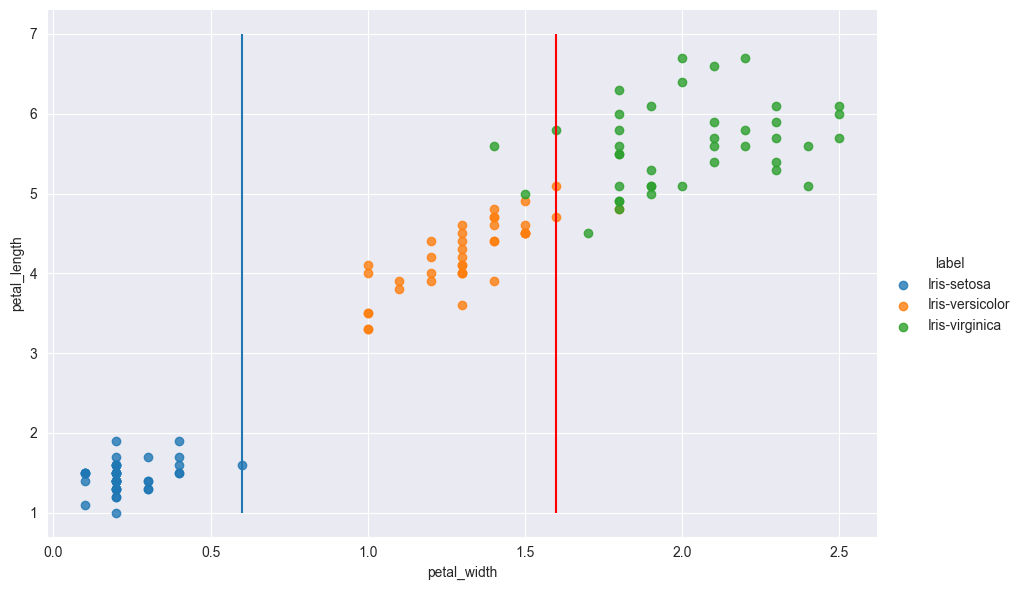

In [481]:
set_feature_types(type_of_features(train_df))
best_split_feature1 , best_split_value1 = fit_best_split(train_df.values , 'classification')
below , above = split_data(train_df.values , best_split_feature1 , best_split_value1 )
_ , best_split_value2 = fit_best_split(above , 'classification')
sns.lmplot(data = train_df,x = "petal_width",y='petal_length',hue='label',fit_reg = False , height  = 6 , aspect = 1.5 )
plt.vlines(x = best_split_value1, ymin = 1 , ymax = 7 )
plt.vlines(x = best_split_value2, ymin = 1 , ymax = 7 ,colors="red")

print(best_split_value1)
print(best_split_value2)

##### It seems that fit_best_split works fine